#COLAB Load
(uncomment if colab used and change paths accordingly in next section)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Different parameters, train-test split and paths

In [ ]:
##params

test_percent = 0.2# @param {type: "slider", min:0.05, max:0.5, step:0.05}
BATCH_SIZE = 32# @param {type: "slider", min:0, max:128 ,step:8}
epoch_no = 50 #@param {type: "slider", min:1, max:50}
no_of_channels = 3# @param {type: "slider", min:1, max:4}

##paths

#dataset_path = "/content/drive/MyDrive/data/comb_dt_splits/aug_train"
dataset_path = "C:/Users/AdminUser/Desktop/Ensemble Model/Dataset/aug_train"
#model_savepath = "/content/drive/MyDrive/affan/resnet.h5"
model_savepath = "C:/Users/AdminUser/Desktop/Ensemble Model/Models/resnet50v2_0.h5"

#Keras Architecture and other Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import random
import cv2
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras import preprocessing

#from google.colab.patches import cv2_imshow
import gc

In [ ]:
from tensorflow.keras.applications import ResNet50V2

# Data Load into Numpy array with respective labels and Split

In [ ]:
DATADIR = dataset_path
FOLDERS = ["B","M"]       #one folder is for M and one for B
CATEGORIES = ["B", "M"]   #there are two categories here for the target variable
NUM_CLASSES = 2           #two classes for the classification
IMG_SIZE = 224            #size of an input image 

In [ ]:
# Data Read Function

def read_data():
    images = [] 
    labels = []
    img_paths = []
    data = []

    for category,folder in zip(CATEGORIES,FOLDERS):        # do B and M 
        path = os.path.join(DATADIR,folder)                # create path to B and M  
        class_num = CATEGORIES.index(category)             # get the classification  (0 or a 1). 0=B and 1=M
        
        for i,img_path in enumerate(tqdm(os.listdir(path))):             # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img_path))      # convert to array
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size                
                img_paths.append(os.path.join(path,img_path))
                
                data.append([img_array, class_num])  # add this to our training_data
                images.append(img_array)
                labels.append(class_num)
            except Exception as e:                 # in the interest in keeping the output clean...
                pass

    images = np.array(images)                     # output images into np array
    images = np.asarray(images).astype(np.float32)
    labels = np.array(labels)                     # output labels into np array
    

    return images,labels,img_paths 

In [ ]:
images,labels = read_data()             # Function call read data
print(len(images))                      # to check the length
print(len(labels))
images.shape                            # to match with input shape to the Architecture

100%|██████████| 5600/5600 [00:10<00:00, 515.12it/s]


11680
11680


(11680, 224, 224, 3)

In [ ]:
images = images/255         ##rescaling for less computational power
X = images

##train-test split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = test_percent, random_state=42)

#Define the Architecture and Tensorflow GPU strategy

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, no_of_channels))
    outputs = ResNet50V2(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
    )

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

#Training and Save trained Model

In [ ]:
histories = []
scores = []


##one_hot: scale into 0-1 vector 
y_train = tf.one_hot(y_train, NUM_CLASSES)  
y_test = tf.one_hot(y_test, NUM_CLASSES)

3callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = "true", mode='auto')


## Training step
#hist = model.fit(X_train,y_train, epochs=epoch_no, validation_data=(X_test,y_test), callbacks=[callback], verbose=2, batch_size=BATCH_SIZE)
hist = model.fit(X_train,y_train, epochs=epoch_no, validation_data=(X_test,y_test), verbose=2, batch_size=BATCH_SIZE)

gc.collect()

## Metrics for plotting
histories.append(hist)
score = model.evaluate(X_test,y_test, verbose=0)
scores.append(score)


Epoch 1/50
292/292 - 84s - loss: 0.5257 - accuracy: 0.7283 - val_loss: 0.6430 - val_accuracy: 0.6640
Epoch 2/50
292/292 - 56s - loss: 0.4833 - accuracy: 0.7493 - val_loss: 0.4818 - val_accuracy: 0.7658
Epoch 3/50
292/292 - 57s - loss: 0.4597 - accuracy: 0.7626 - val_loss: 0.4817 - val_accuracy: 0.7568
Epoch 4/50
292/292 - 57s - loss: 0.4390 - accuracy: 0.7750 - val_loss: 14.0631 - val_accuracy: 0.5081
Epoch 5/50
292/292 - 58s - loss: 0.4170 - accuracy: 0.7892 - val_loss: 0.6862 - val_accuracy: 0.6259
Epoch 6/50
292/292 - 58s - loss: 0.3791 - accuracy: 0.8158 - val_loss: 0.3963 - val_accuracy: 0.8031
Epoch 7/50
292/292 - 59s - loss: 0.3399 - accuracy: 0.8365 - val_loss: 0.4731 - val_accuracy: 0.7590
Epoch 8/50
292/292 - 59s - loss: 0.3215 - accuracy: 0.8530 - val_loss: 0.4971 - val_accuracy: 0.7359
Epoch 9/50
292/292 - 58s - loss: 0.3090 - accuracy: 0.8553 - val_loss: 1.0537 - val_accuracy: 0.6584
Epoch 10/50
292/292 - 58s - loss: 0.2930 - accuracy: 0.8648 - val_loss: 7.0917 - val_accur

In [ ]:
model.save(model_savepath)
print("Saved model to disk")

C:\Users\AdminUser\anaconda3\envs\ensemble_gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk


#Plots

In [ ]:
score = scores[0]
print(score)

[0.17983593046665192, 0.9460616707801819]


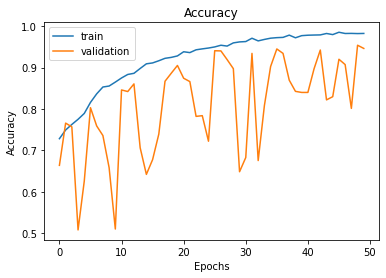

In [ ]:
def plot_accuracy(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_accuracy(hist)

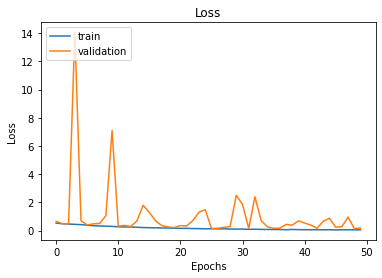

In [ ]:
def plot_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_loss(hist)